<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/pseudotime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Wed Aug 19 16:45:58 UTC 2020


In [ ]:
#Read in kallisto bus fed/starved data
#!wget --quiet https://caltech.box.com/shared/static/13jsqkczkskrf6cau9p4evhnmqyp7jn3
!wget --quiet https://caltech.box.com/shared/static/glwk0aln8a3osfuffab73a47js8n0f4w

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

In [ ]:
#Previously saved neuron subpopulations
!wget --quiet https://caltech.box.com/shared/static/pxsxk2l24jsmsxx03nkd4isj9a2fk7ek

#Big lineage pseudotime genes
!wget --quiet https://caltech.box.com/shared/static/hhrf2px9qpchvsyjaasffvbllop498jd

In [ ]:
#Human ortholog annotations
!wget --quiet https://caltech.box.com/shared/static/slxs7968tths1xotumohnzwy6pgdtk6k

#Panther annotations
!wget --quiet https://caltech.box.com/shared/static/vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt

#GO Terms
!wget --quiet https://caltech.box.com/shared/static/0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof

In [ ]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

!pip install --quiet louvain

     |████████████████████████████████| 122kB 4.2MB/s 
     |████████████████████████████████| 7.7MB 4.5MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 2.4MB 4.4MB/s 
     |████████████████████████████████| 3.2MB 27.4MB/s 
     |████████████████████████████████| 2.2MB 4.2MB/s 


In [ ]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")


In [ ]:
#Read in annotation data
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('slxs7968tths1xotumohnzwy6pgdtk6k'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]
#hg_ortho_df.head()

panther_df = pd.read_csv('vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt',
            sep="\t",header=None) #skiprows=[0,1,2,3]

#panther_df.head()

goTerm_df = pd.read_csv('0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof',
            sep=" ",header=None) #skiprows=[0,1,2,3]

#goTerm_df.head()

In [ ]:
#Read in saved data
bus_fs_combo = anndata.read('glwk0aln8a3osfuffab73a47js8n0f4w')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('3l60szs0e9hgaax4q9dbuehgoo092xww')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
bus_fs_raw.obs['annos'] = pd.Categorical(bus_fs_combo.obs['annos'])
bus_fs_raw.obs['annosSub'] = pd.Categorical(bus_fs_combo.obs['annosSub'])

bus_fs_raw.uns['annos_colors'] = bus_fs_combo.uns['annos_colors']
bus_fs_raw.uns['cellRanger_louvain_colors'] = bus_fs_combo.uns['annosSub_colors']
#bus_fs_raw.uns['annosSub_colors'] = bus_fs_combo.uns['annosSub_colors']
print(bus_fs_raw)

neuron_subpops  = anndata.read('pxsxk2l24jsmsxx03nkd4isj9a2fk7ek') 
print(neuron_subpops)

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'
AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain'

In [ ]:
#Random forest regression to determine best genes to predict pseudotime
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
def runRegr_dptPseudotime(adata,adata_scaled,label='dpt_pseudotime'):
  X = adata.X
  if scipy.sparse.issparse(X):
    X = X.toarray()
  
  #80% training data
  perc = 0.8
  n = np.int(perc*X.shape[0])

  np.random.seed(0)
  indices = np.random.choice(X.shape[0], n, replace=False,)
  X_train = X[indices,:]

  y = adata_scaled.obs[label]
  y_train = y[indices]

  X_test = X[[i for i in range(0,X.shape[0]) if i not in indices],:]
  y_test = y[[i for i in range(0,X.shape[0]) if i not in indices]]

  regr = RandomForestRegressor(random_state=42,max_samples=perc)
  regr.fit(X_train, y_train)
  print(regr.score(X_test, y_test))
  result = permutation_importance(regr, X_test, y_test, n_repeats=5, random_state=42)
  
  return result

#Convert filtered results to dataframe
def resToDF(result,adata):
  neur_gene_res = pd.DataFrame()
  neur_gene_res['Genes'] = adata.var_names
  neur_gene_res['Mean'] = result.importances_mean
  neur_gene_res['Std'] = result.importances_std

  neur_gene_res= neur_gene_res.sort_values('Mean', axis=0, ascending=False)

  neur_gene_res= neur_gene_res[neur_gene_res.Mean > 0]

  print(len(neur_gene_res.Genes))

  return neur_gene_res

#Make dataframe, with 100 marker genes for each cluster + annotations
def annotateResDF(resultDF):
  orthoGene = []
  orthoDescr = []

  pantherNum = []
  pantherDescr = []

  goTerms = []

  genes = resultDF.Genes

  for g in genes:
          
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
  

  resultDF['orthoGene'] = orthoGene
  resultDF['orthoDescr'] = orthoDescr

  resultDF['pantherID'] = pantherNum
  resultDF['pantherDescr'] = pantherDescr

  resultDF['goTerms'] = goTerms
      
  return resultDF
  #list(neurons.uns['rank_genes_groups']['names']['1'])

#Order cells in cell-by-gene matrix by pseudotime
def orderTime(adata):
  sortTime = np.argsort(adata.obs['dpt_pseudotime'])
  newNames = adata.obs_names[list(sortTime)]

  adataRet = adata[newNames,:]
  return adataRet


###**I-cells, Neurons, Nematocytes**

In [ ]:
#Subset data

#I-cells, neurons, nematocytes
big_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23])]


sc.pp.filter_cells(big_lin, min_counts=0)
sc.pp.filter_genes(big_lin, min_counts=1)
sc.pp.normalize_per_cell(big_lin, counts_per_cell_after=1e4)

big_lin_copy = big_lin.copy()
sc.pp.log1p(big_lin)

big_lin.raw = sc.pp.log1p(big_lin_copy, copy=True)


sc.pp.highly_variable_genes(big_lin, n_top_genes=4000,n_bins=50)

big_lin = big_lin[:,big_lin.var['highly_variable']]

big_lin



Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4064 × 4000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg'

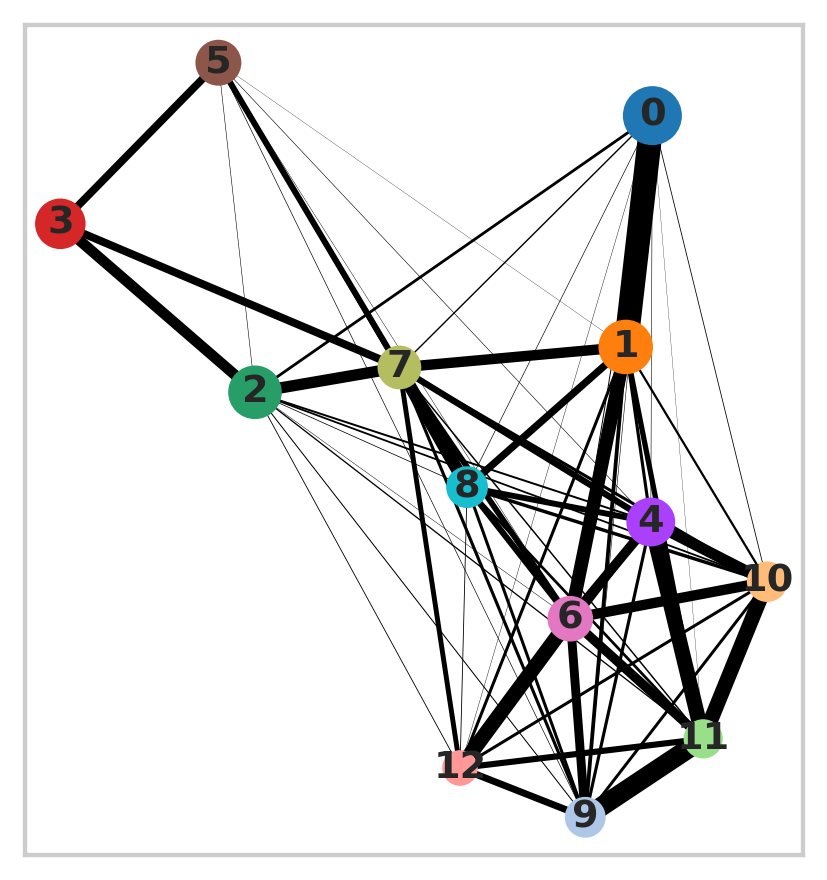

In [ ]:
#Large lineage PAGA embedding

big_lin_scaled = big_lin
sc.pp.scale(big_lin_scaled, max_value=10)

sc.tl.pca(big_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(big_lin_scaled,n_neighbors=50, n_pcs=15,method='gauss')

sc.tl.louvain(big_lin_scaled,resolution=1,key_added='louvain_test')#Clustering algorithm,resolution=0.5


sc.tl.paga(big_lin_scaled, groups='louvain_test',)
sc.pl.paga(big_lin_scaled, color=['louvain_test'])

In [ ]:
#Add neuron subpopulation labels
# labels = []
# for c in big_lin_scaled.obs_names:
#   if c in neuron_subpops.obs_names:

#     labels += [neuron_subpops[c,:].obs['louvain_neur'][0]]
#   else:
#     labels += ['rest']

# big_lin_scaled.obs['louvain_neur'] = pd.Categorical(labels)

In [ ]:
sc.tl.draw_graph(big_lin_scaled, init_pos='paga')
#sc.pl.draw_graph(big_lin_scaled, color=['louvain_test','louvain_neur','cellRanger_louvain','fed'], legend_loc='on data',color_map='viridis',alpha=0.5)

In [ ]:
#Calculate pseudotime with diffusion components (dim reduction)

big_lin_scaled.uns['iroot'] = np.flatnonzero(big_lin_scaled.obs['louvain_test']  == '0')[0]
sc.tl.diffmap(big_lin_scaled,n_comps=10)
sc.tl.dpt(big_lin_scaled,n_dcs=10)


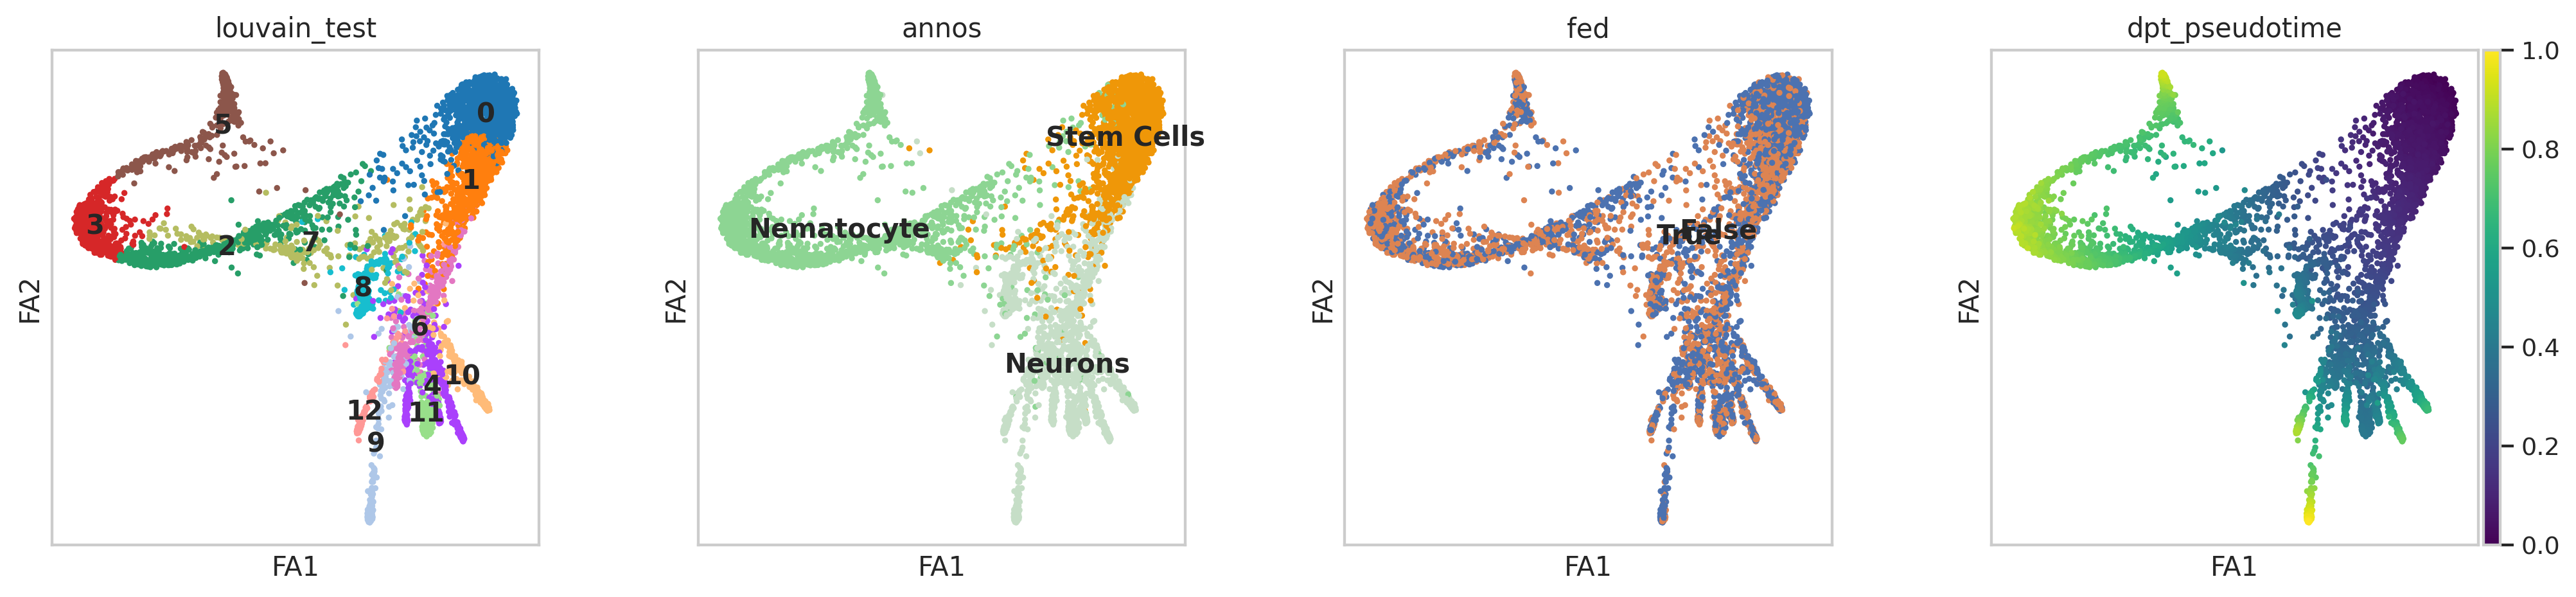

In [ ]:
sc.pl.draw_graph(big_lin_scaled, color=['louvain_test','annos','fed','dpt_pseudotime'], 
                 legend_loc='on data',color_map='viridis')

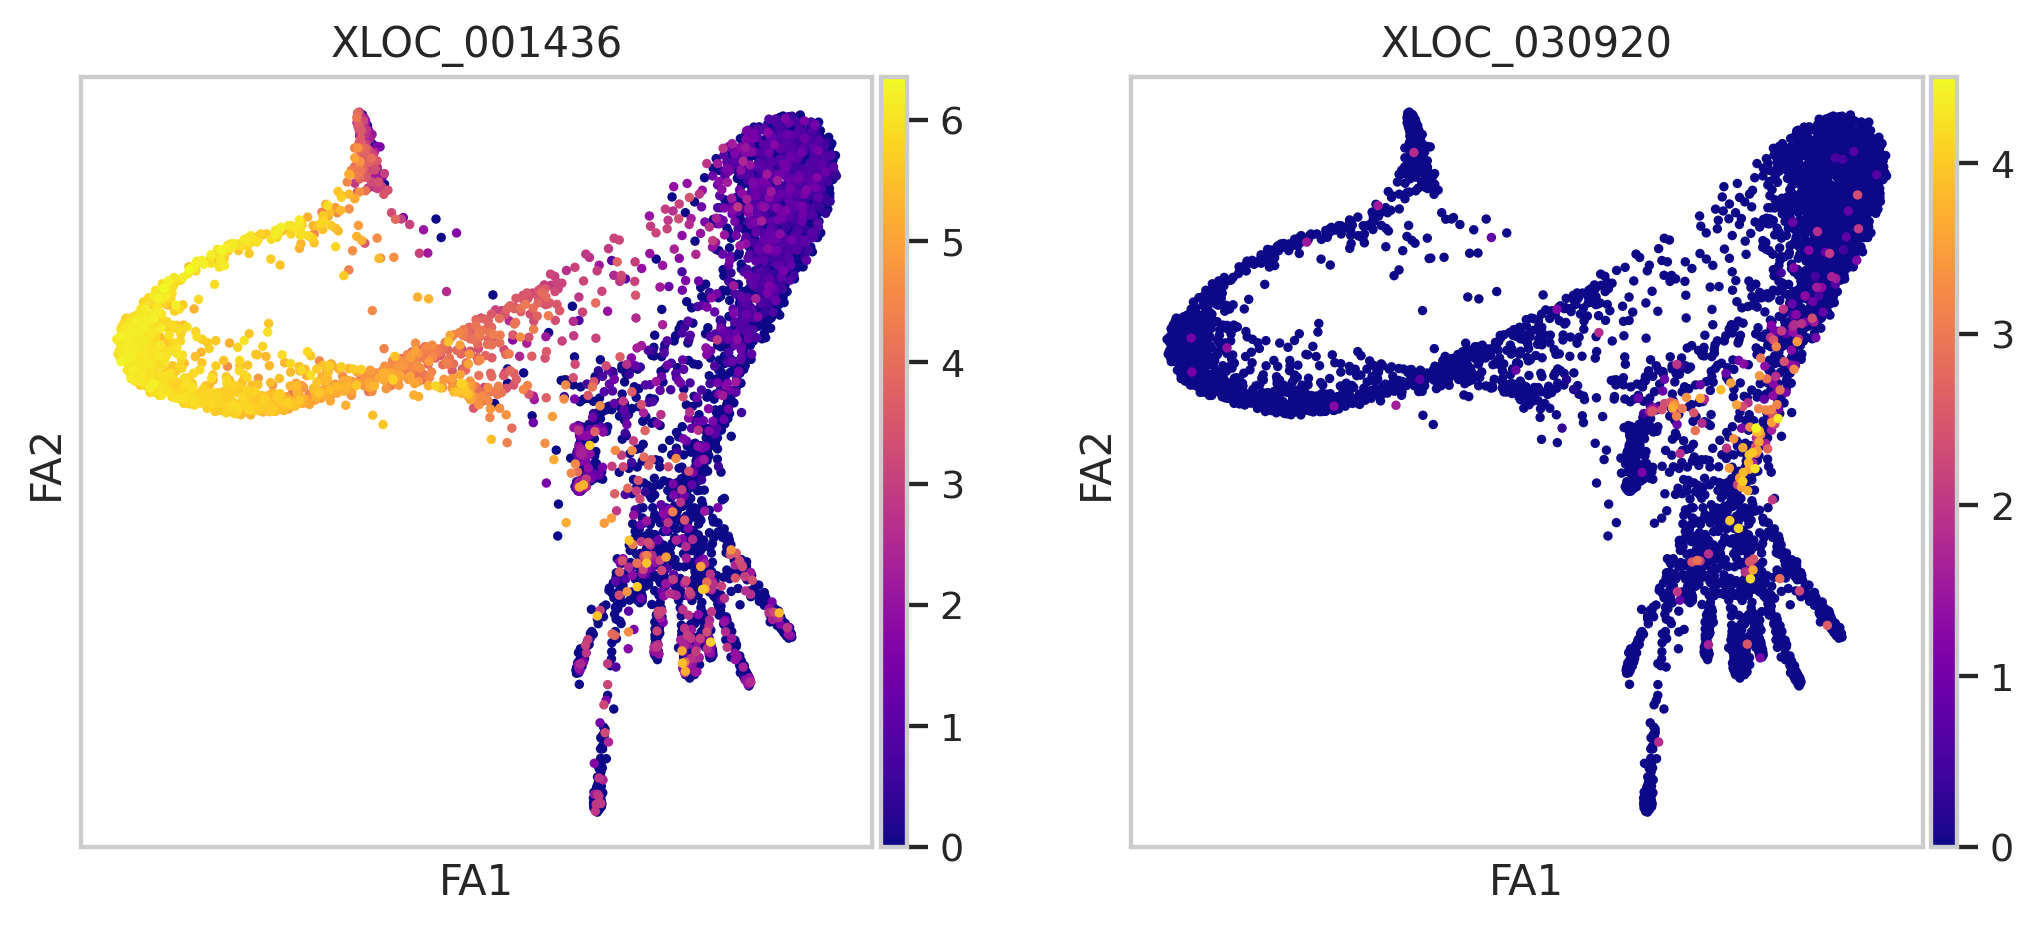

In [ ]:
sc.pl.draw_graph(big_lin_scaled, color=['XLOC_001436','XLOC_030920'], 
                 legend_loc='on data',color_map='plasma')

In [ ]:

#timeLabels = pd.cut(big_lin_scaled.obs['dpt_pseudotime'],bins=10,labels=strList)
# quantTimeLabels = pd.qcut(big_lin_scaled.obs['dpt_pseudotime'],q=nbins,labels=strList)

# big_lin_scaled.obs['quantTimeBlocks'] = quantTimeLabels

In [ ]:
#Make adata for doing regression (more variable genes included)
big_lin_reg = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23])]


sc.pp.filter_cells(big_lin_reg, min_counts=0)
sc.pp.filter_genes(big_lin_reg, min_counts=1)
sc.pp.normalize_per_cell(big_lin_reg, counts_per_cell_after=1e4)

big_lin_copy = big_lin_reg.copy()
sc.pp.log1p(big_lin_reg)

big_lin_reg.raw = sc.pp.log1p(big_lin_copy, copy=True)

#For shorter demonstration use 4000 option
#sc.pp.highly_variable_genes(big_lin_reg, n_top_genes=4000,n_bins=10)
sc.pp.highly_variable_genes(big_lin_reg, n_top_genes=15000,n_bins=10) 

big_lin_reg = big_lin_reg[:,big_lin_reg.var['highly_variable']]


Trying to set attribute `.obs` of view, copying.


In [ ]:
#Convert pseudotime valeus to quantiles of pseudotime 
big_lin_reg.obs['dpt_pseudotime'] = big_lin_scaled.obs['dpt_pseudotime']

nbins = 20 #quantiles
rangeList = range(0,nbins)
strList = [str(i) for i in rangeList]

cnido = big_lin_reg[big_lin_reg.obs['cellRanger_louvain'].isin([0,11,12,17,23])]
cnido.obs['quantTimeBlocks'] = pd.qcut(cnido.obs['dpt_pseudotime'],q=nbins,labels=strList)

neuro = big_lin_reg[big_lin_reg.obs['cellRanger_louvain'].isin([0,26,31,9,6])]
neuro.obs['quantTimeBlocks'] = pd.qcut(neuro.obs['dpt_pseudotime'],q=nbins,labels=strList)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


#### **Run Regression**

In [ ]:
#Run regression
#result_big = runRegr_dptPseudotime(big_lin_reg,big_lin_scaled,'quantTimeBlocks')
result_cnido = runRegr_dptPseudotime(cnido,cnido,'quantTimeBlocks')
result_neuro = runRegr_dptPseudotime(neuro,neuro,'quantTimeBlocks')

0.9252565851716389
0.8683961569750528


In [ ]:
#big_gene_res = resToDF(result_big,big_lin_reg)
#big_gene_res.head()

#Make dataframe from regression results
cnido_gene_res = resToDF(result_cnido,cnido)
neuro_gene_res = resToDF(result_neuro,neuro)


2202
2186


In [ ]:
cnido_gene_res = annotateResDF(cnido_gene_res)
neuro_gene_res = annotateResDF(neuro_gene_res)
cnido_gene_res.head()

Genes  ...                                            goTerms
629    XLOC_001436  ...                                              [nan]
631    XLOC_001437  ...                                                 NA
3242   XLOC_008048  ...  [GO:0032502,GO:0016337,GO:0007398,GO:0007498,G...
7688   XLOC_021750  ...  [GO:0000910,GO:0005856,GO:0005200,GO:0006897,G...
12680  XLOC_039385  ...  [GO:0016787,GO:0005615,GO:0044238,GO:0019538,G...

[5 rows x 8 columns]

In [ ]:
cnido_gene_res.to_csv('cnido_stem_lineage_pseudotime_genes.csv')
neuro_gene_res.to_csv('neuro_stem_lineage_pseudotime_genes.csv')

#### **Plot Results of Regression**

In [ ]:

toAddNeuro = ['XLOC_037011','XLOC_031923','XLOC_010412','XLOC_030920','XLOC_026271','XLOC_025094','XLOC_018937','XLOC_037278','XLOC_009173','XLOC_033489',
                                        'XLOC_010752','XLOC_045293','XLOC_033337','XLOC_012650']
toAddNeuroNames = ['TUBA4A','PCNA','GLUL','Ngn','DCX','CALR','Ngn3','TAGLN-2','H2AFV','PRDX4',
                          'NEUROD4','*SOX-10','CL1','Unknown3']

toAddNeuroDict = {}
for i in range(0,len(toAddNeuro)):
  toAddNeuroDict[toAddNeuro[i]] = toAddNeuroNames[i]


toAddCnido = ['XLOC_001436','XLOC_008048','XLOC_030068','XLOC_011074','XLOC_041365','XLOC_041836','XLOC_011949','XLOC_015554']
toAddCnidoNames = ['*Mcol3/4','Mcol','*Dkk3','TUBA1C','TF IIIA','NACA2','BOP1','*Mos3']
toAddCnidoDict = {}
for i in range(0,len(toAddCnido)):
  toAddCnidoDict[toAddCnido[i]] = toAddCnidoNames[i]



# sc.pl.draw_graph(big_lin_scaled, color=toAddNeuro+toAddCnido,
#                  legend_loc='on data',color_map='viridis',s=45,use_raw=True,vmin=0,vmax=5,
#                  title = toAddNeuroNames+toAddCnidoNames)
                 

In [ ]:
#Determine where var_names is in list of genesToPlot
allGenes = {**toAddCnidoDict, **toAddNeuroDict}

forPlotNeuro = ['XLOC_031923','XLOC_009173','XLOC_026271','XLOC_018937','XLOC_045293','XLOC_030920','XLOC_010752','XLOC_037011','XLOC_033337','XLOC_012650']
forPlotCnido = ['XLOC_011949','XLOC_011074','XLOC_041836','XLOC_015554','XLOC_041365','XLOC_030068','XLOC_008048','XLOC_001436']

#forPlot = forGraphPlot + toAddTime


In [ ]:
# forPlotCnido = ['XLOC_032238','XLOC_037906','','','XLOC_026271','','XLOC_034527','',
#            'XLOC_041836','','XLOC_045293','XLOC_030920','XLOC_011684','XLOC_037011','XLOC_001436','XLOC_008048',
#            'XLOC_041365','XLOC_042879','XLOC_011400','XLOC_045474','XLOC_006386','XLOC_000865','XLOC_030068']

labelsCnido = [allGenes[i] for i in forPlotCnido]
labelsNeuro = [allGenes[i] for i in forPlotNeuro]

#Order cells by pseudotime (0 --> 1)
orderCnido = orderTime(cnido)
orderNeuro = orderTime(neuro)

orderCnido = orderCnido[:,forPlotCnido]
orderCnido.var['names'] = labelsCnido


orderNeuro = orderNeuro[:,forPlotNeuro]
orderNeuro.var['names'] = labelsNeuro

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


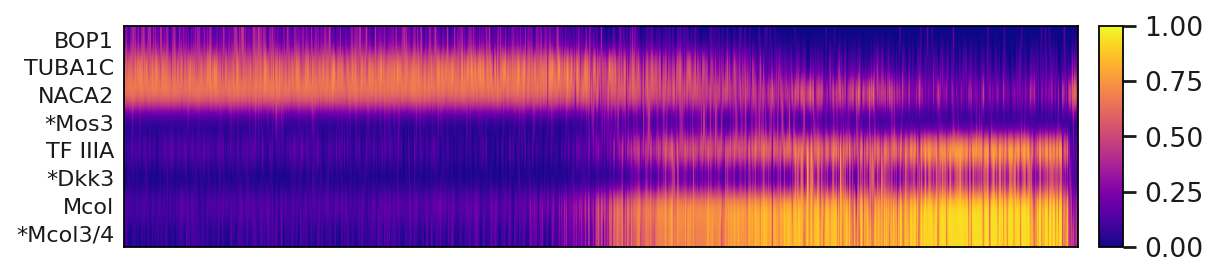

In [ ]:

sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderCnido, labelsCnido, groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='var',
              interpolation='gaussian',cmap='plasma',swap_axes=True,gene_symbols='names',figsize=(8,2),
              save='cnido_gauss_BigLinTimeGenes.pdf')

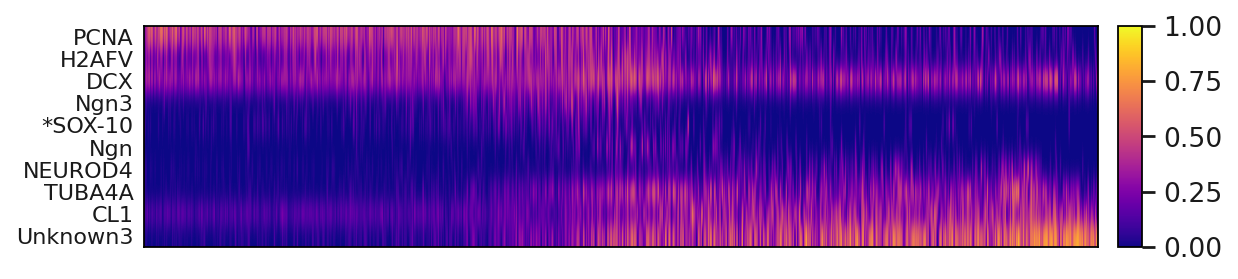

In [ ]:
sc.pl.heatmap(orderNeuro, labelsNeuro, groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='var',
              interpolation='gaussian',cmap='plasma',swap_axes=True,gene_symbols='names', figsize=(8,2),
              save='neuro_gauss_BigLinTimeGenes.pdf')

### **Check gland cell trajectories and/or hair cells**

In [ ]:
#Subset data

#Gland cells: 27,25,32,34,22 + no 31,26,6,9
#Actually including sensory hair cell populations, 5, 10, 21
gland_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([5,10,21,0,11,12,17,23])]


sc.pp.filter_cells(gland_lin, min_counts=0)
sc.pp.filter_genes(gland_lin, min_counts=1)
sc.pp.normalize_per_cell(gland_lin, counts_per_cell_after=1e4)

sc.pp.log1p(gland_lin)


sc.pp.highly_variable_genes(gland_lin, n_top_genes=4000,n_bins=50)

gland_lin = gland_lin[:,gland_lin.var['highly_variable']]

gland_lin



Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4094 × 4000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg'

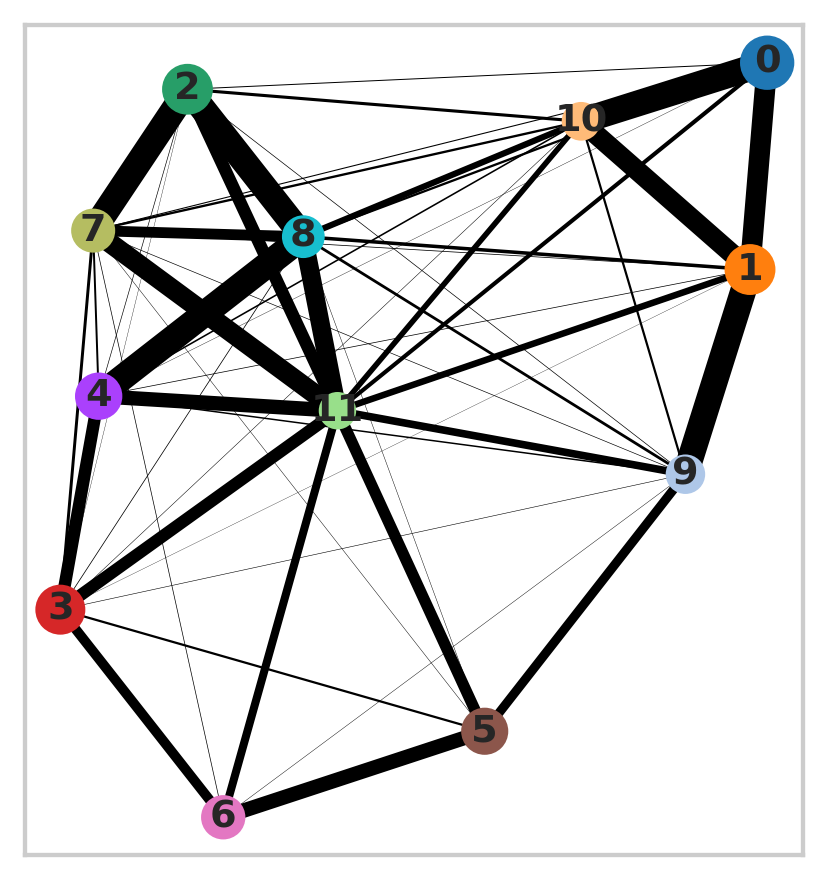

In [ ]:
#Large lineage PAGA embedding

gland_lin_scaled = gland_lin
sc.pp.scale(gland_lin_scaled, max_value=10)

sc.tl.pca(gland_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(gland_lin_scaled,n_neighbors=100, n_pcs=60,method='gauss')

sc.tl.louvain(gland_lin_scaled,resolution=2,key_added='louvain_test')#Clustering algorithm,resolution=0.5


sc.tl.paga(gland_lin_scaled, groups='louvain_test',)
sc.pl.paga(gland_lin_scaled, color=['louvain_test'])

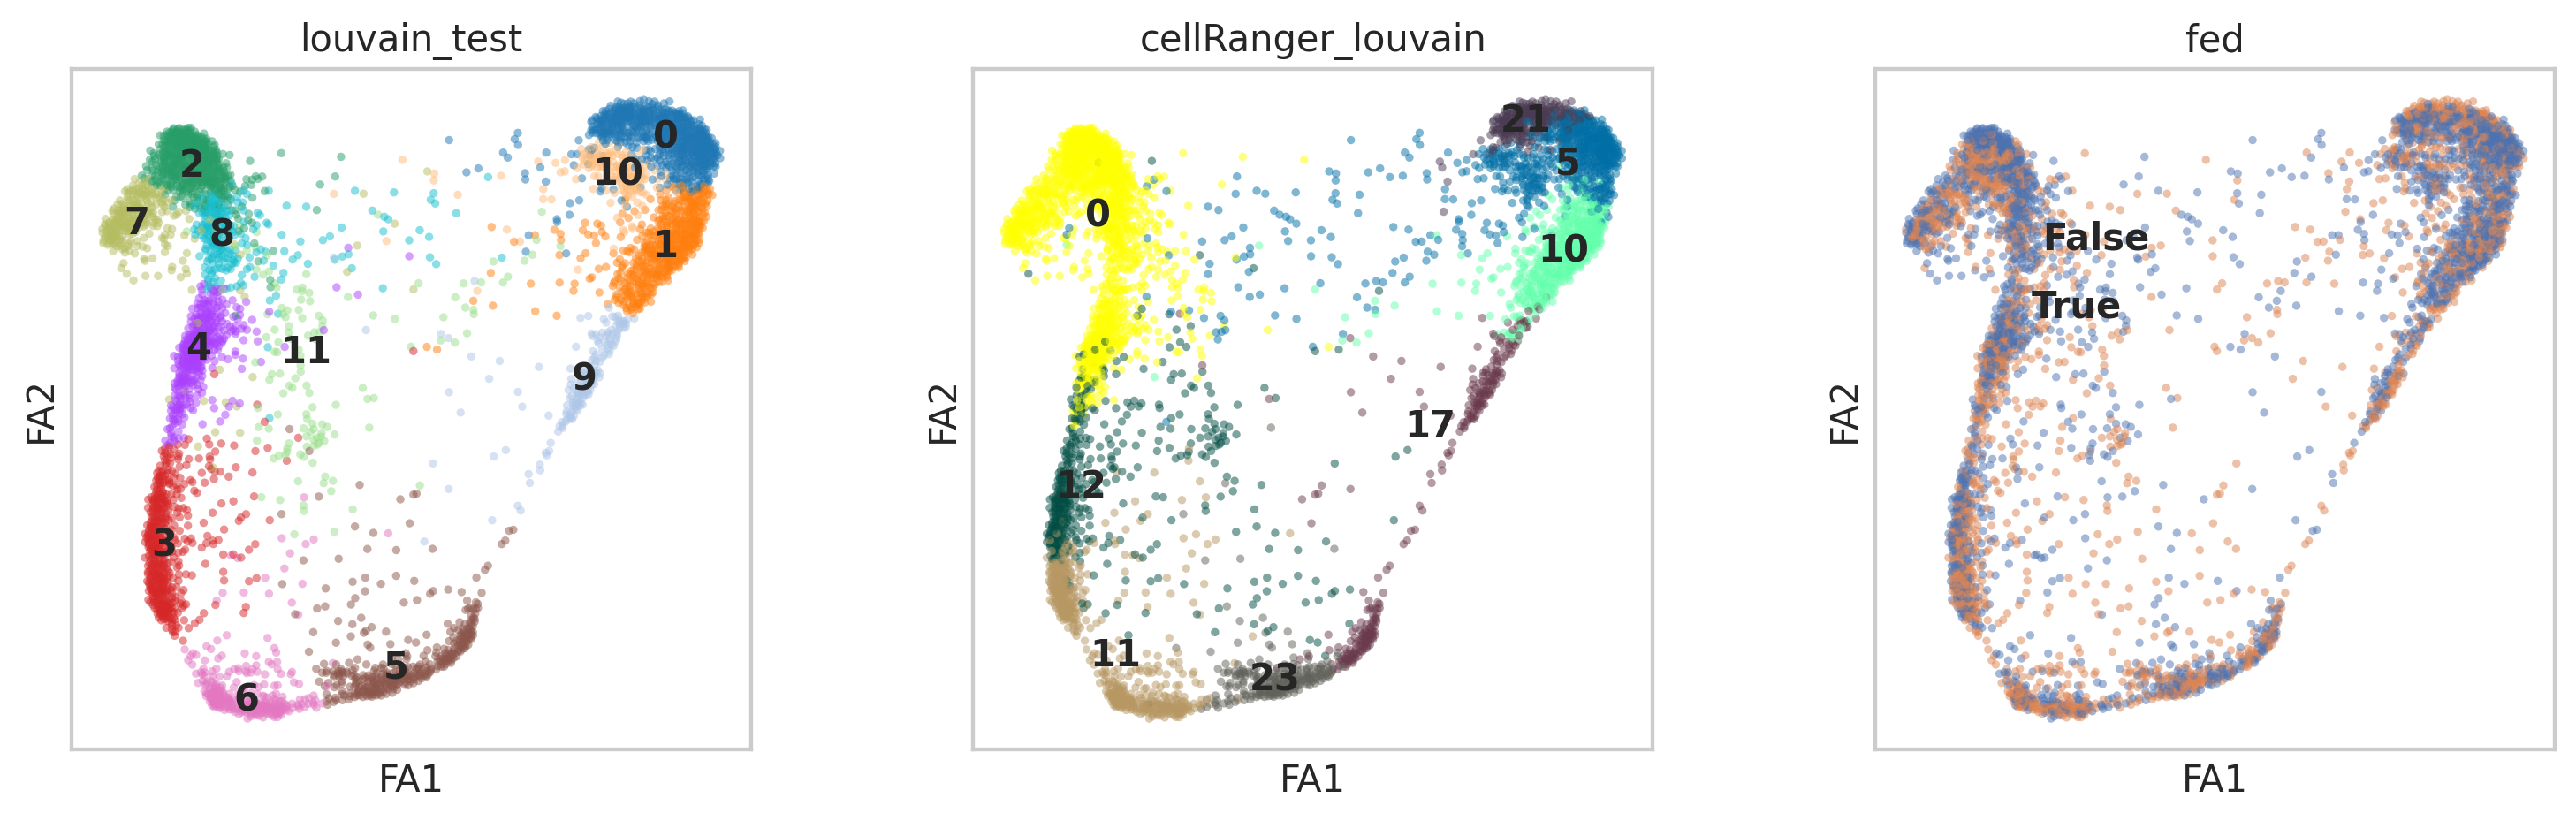

In [ ]:
sc.tl.draw_graph(gland_lin_scaled, init_pos='paga') #'louvain_test'
sc.pl.draw_graph(gland_lin_scaled, color=['louvain_test','cellRanger_louvain','fed'], 
                 legend_loc='on data',color_map='viridis',alpha=0.5)

In [ ]:
#Calculate pseudotime with diffusion components (dim reduction)

gland_lin_scaled.uns['iroot'] = np.flatnonzero(gland_lin_scaled.obs['louvain_test']  == '2')[0]
sc.tl.diffmap(gland_lin_scaled,n_comps=10)
sc.tl.dpt(gland_lin_scaled,n_dcs=10)

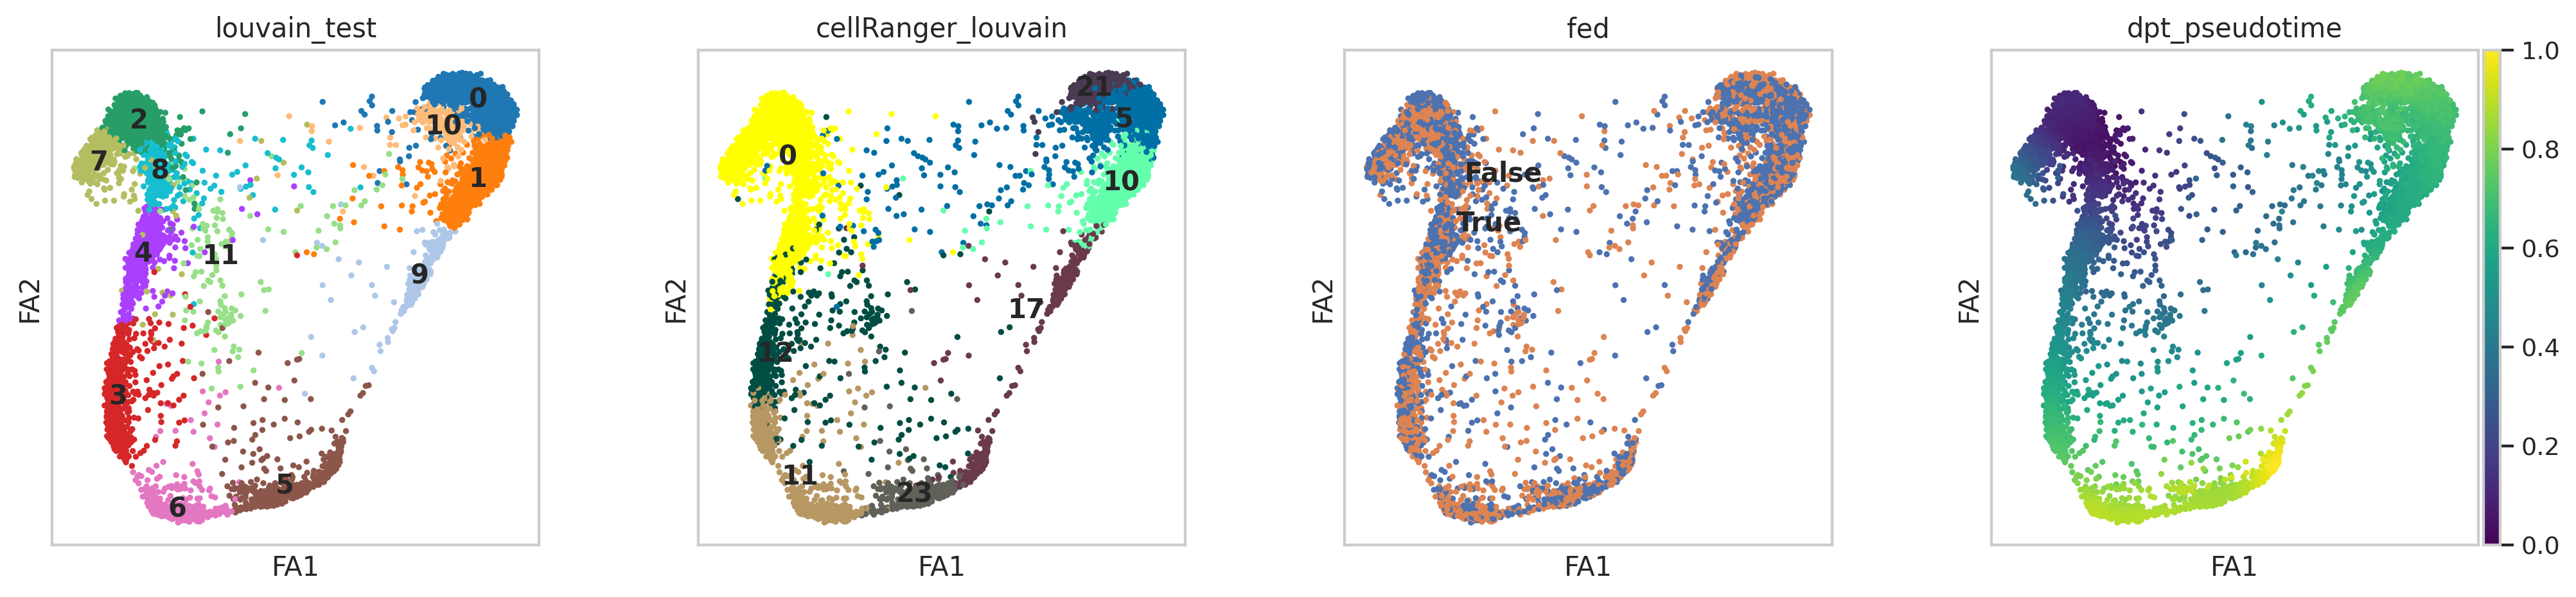

In [ ]:
sc.pl.draw_graph(gland_lin_scaled, color=['louvain_test','cellRanger_louvain','fed','dpt_pseudotime'], 
                 legend_loc='on data',color_map='viridis')

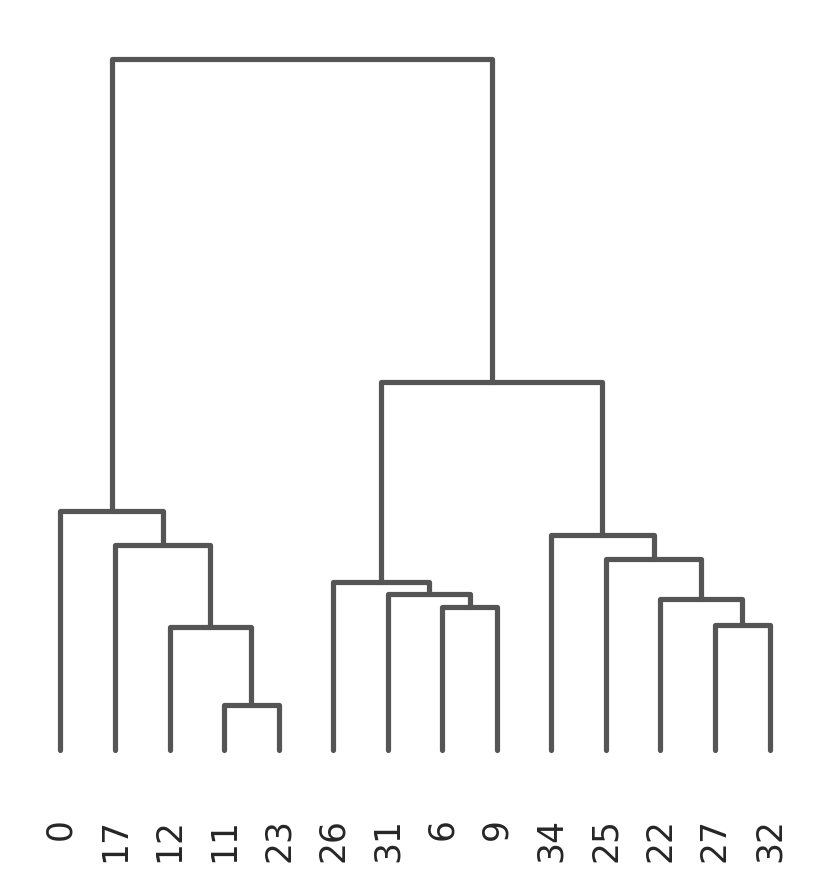

In [ ]:
sc.tl.dendrogram(gland_lin_scaled,'cellRanger_louvain',linkage_method='ward')
gland_lin_scaled.uns['dendrogram_cellRanger_louvain'] = gland_lin_scaled.uns["dendrogram_['cellRanger_louvain']"]
sc.pl.dendrogram(gland_lin_scaled,'cellRanger_louvain')

In [ ]:
nbins = 10
rangeList = range(0,nbins)
strList = [str(i) for i in rangeList]
#timeLabels = pd.cut(big_lin_scaled.obs['dpt_pseudotime'],bins=10,labels=strList)
quantTimeLabels = pd.qcut(gland_lin_scaled.obs['dpt_pseudotime'],q=10,labels=strList)

gland_lin_scaled.obs['quantTimeBlocks'] = quantTimeLabels

In [ ]:
gland_lin_reg = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23,27,25,32,34,22])]


sc.pp.filter_cells(gland_lin_reg, min_counts=0)
sc.pp.filter_genes(gland_lin_reg, min_counts=1)
sc.pp.normalize_per_cell(gland_lin_reg, counts_per_cell_after=1e4)

gland_lin_copy = gland_lin_reg.copy()
sc.pp.log1p(gland_lin_reg)

gland_lin_reg.raw = sc.pp.log1p(gland_lin_copy, copy=True)

#For shorter demonstration
#sc.pp.highly_variable_genes(big_lin_reg, n_top_genes=4000,n_bins=10)
sc.pp.highly_variable_genes(gland_lin_reg, n_top_genes=15000,n_bins=10) #Uncomment to run on more genes

gland_lin_reg = gland_lin_reg[:,gland_lin_reg.var['highly_variable']]

print('XLOC_030920' in list(gland_lin_reg.var_names)) #big_gene_res.Genes
print('XLOC_045293' in list(gland_lin_reg.var_names))

Trying to set attribute `.obs` of view, copying.


True
True


In [ ]:
#Run regression
result_gland = runRegr_dptPseudotime(gland_lin_reg,gland_lin_scaled,'quantTimeBlocks')

0.8942625633772597


In [ ]:
gland_gene_res = resToDF(result_gland,gland_lin_reg)
gland_gene_res.head()

2811


Genes      Mean       Std
14342                    XLOC_044101  0.197080  0.013774
14371                    XLOC_044068  0.099149  0.004948
4387                     XLOC_011074  0.027705  0.003188
4167                     XLOC_010444  0.023599  0.002362
8967   TRINITY_DN5607_c0_g1_i2.mrna1  0.022221  0.003038

In [ ]:
print('XLOC_030920' in list(gland_gene_res.Genes)) #Neurogenin
print('XLOC_045293' in list(gland_gene_res.Genes)) #SOX10

print('XLOC_044122' in list(gland_gene_res.Genes)) #minicollagen
print('XLOC_030068' in list(gland_gene_res.Genes)) #dickopff

print('XLOC_015554' in list(gland_gene_res.Genes)) #Mos 3



True
True
False
True
True


In [ ]:
#Print plots of genes in batches
n=50
for i in range(0, n, n):#
  if (i+n) > len(gland_gene_res.Genes):
    sc.pl.draw_graph(gland_lin_scaled, color=gland_gene_res.Genes[i:], 
                     legend_loc='on data',color_map='viridis',save='clus0Root_gauss_'+str(i)+'_GlandLinTimeGenes.pdf',s=15,use_raw=True)
  else:
    sc.pl.draw_graph(gland_lin_scaled, color=gland_gene_res.Genes[i:i+n], 
                     legend_loc='on data',color_map='viridis',save='clus0Root_gauss_'+str(i)+'_GlandLinTimeGenes.pdf',s=15,use_raw=True)
    

KeyError: ignored

<Figure size 2415x6500 with 0 Axes>

In [ ]:
gland_gene_res = annotateResDF(gland_gene_res)
gland_gene_res.head()

Genes  ...                                            goTerms
9638                     XLOC_030930  ...  [GO:0044238,GO:0016853,GO:0019538,GO:0009987,G...
14364                    XLOC_044068  ...                                              [nan]
4963                     XLOC_012650  ...                                                 NA
4295                     XLOC_010810  ...                                              [nan]
8941   TRINITY_DN5607_c0_g1_i2.mrna1  ...                                                 NA

[5 rows x 8 columns]

In [ ]:
gland_gene_res.to_csv('gland_neur_cnido_stem_lineage_pseudotime_genes.csv')